<a href="https://colab.research.google.com/github/rubanzasilva/flood_prediction/blob/3-mar-24/s04e05_fastai_exp1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install catboost
!pip install fastkaggle

In [62]:
#hide
#! [ -e /content ]

#hide
#This imports and sets up everything you will need for this notebook
#
#!pip install -Uqq fastbook
#import fastbook
#fastbook.setup_book()

#from fastbook import *
#!pip install ucimlrepo
#from ucimlrepo import fetch_ucirepo

from fastai.tabular.all import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import random

from fastai.imports import *
np.set_printoptions(linewidth=130)


from pathlib import Path
import os


from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
#from sklearn.metrics import root_mean_squared_error

import xgboost as xgb
from xgboost import plot_importance

import lightgbm as lgb

from catboost import CatBoostClassifier,CatBoostRegressor,Pool, metrics, cv

from ipywidgets import interact


matplotlib.rc('image', cmap='Greys')

from fastkaggle import setup_comp

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"rubanzasilva","key":"3c109650146efc9c92fc9e8bfe70d487"}'}

In [4]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

#chmod 600 /root/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [6]:
comp = 'playground-series-s4e5'

path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')

100%|██████████| 28.0M/28.0M [00:00<00:00, 92.0MB/s]


In [7]:
!ls

'kaggle (1).json'   playground-series-s4e4   playground-series-s4e5.zip
 kaggle.json	    playground-series-s4e5   sample_data


In [ ]:
#set_seed(42)

In [11]:
path = Path('playground-series-s4e5/')
path

Path('playground-series-s4e5')

In [12]:
train_df = pd.read_csv(path/'train.csv',index_col='id')
test_df = pd.read_csv(path/'test.csv',index_col='id')
sub_df = pd.read_csv(path/'sample_submission.csv',index_col='id')

In [68]:
sub_df

,FloodProbability
id,
1117957,0.5
1117958,0.5
1117959,0.5
1117960,0.5
1117961,0.5
...,...
1863257,0.5
1863258,0.5
1863259,0.5


In [13]:
train_df.head()

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
id,,,,,,,,,,,,,,,,,,,,,
0,5,8,5,8,6,4,4,3,3,4,...,5,3,3,5,4,7,5,7,3,0.445
1,6,7,4,4,8,8,3,5,4,6,...,7,2,0,3,5,3,3,4,3,0.450
2,6,5,6,7,3,7,1,5,4,5,...,7,3,7,5,6,8,2,3,3,0.530
3,3,4,6,5,4,8,4,7,6,8,...,2,4,7,4,4,6,5,7,5,0.535
4,5,3,2,6,4,4,3,3,3,3,...,2,2,6,6,4,1,2,3,5,0.415


In [ ]:
train_df.shape

(1117957, 21)

In [ ]:
train_df.columns

Index(['MonsoonIntensity', 'TopographyDrainage', 'RiverManagement',
       'Deforestation', 'Urbanization', 'ClimateChange', 'DamsQuality',
       'Siltation', 'AgriculturalPractices', 'Encroachments',
       'IneffectiveDisasterPreparedness', 'DrainageSystems',
       'CoastalVulnerability', 'Landslides', 'Watersheds',
       'DeterioratingInfrastructure', 'PopulationScore', 'WetlandLoss',
       'InadequatePlanning', 'PoliticalFactors', 'FloodProbability'],
      dtype='object')

In [14]:
cont_names,cat_names = cont_cat_split(train_df, dep_var='FloodProbability')
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))
to = TabularPandas(train_df, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='FloodProbability',
                   y_block=RegressionBlock(),
                   splits=splits)

X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

dls = to.dataloaders(bs=64)
test_dl = dls.test_dl(test_df)

SuggestedLRs(slide=0.013182567432522774, valley=0.0014454397605732083)

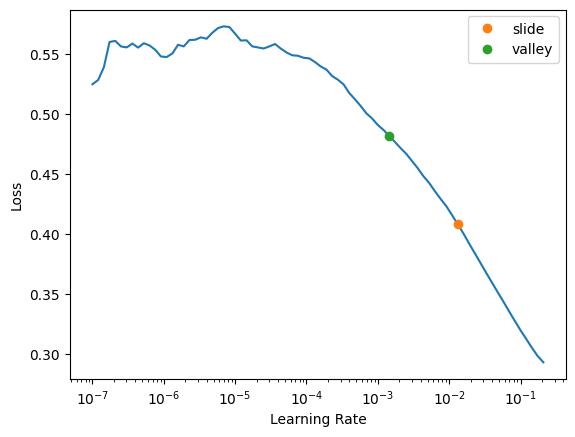

In [15]:
learn = tabular_learner(dls, metrics=R2Score())
learn.lr_find(suggest_funcs=(slide,valley))

In [16]:
learn.fit_one_cycle(4,0.008)

epoch,train_loss,valid_loss,r2_score,time
0,0.000553,0.000507,0.805165,04:06
1,0.000484,0.000418,0.839592,04:35
2,0.000410,0.000383,0.852863,04:23
3,0.000405,0.000371,0.857657,03:52


In [17]:
#learn.fit_one_cycle(8,0.008)
dl = learn.dls.test_dl(test_df)
nn_preds = learn.get_preds(dl=dl)
nn_preds_x = learn.get_preds()[0]
a_preds, _ = learn.get_preds(dl=dl)
nn_preds_y = a_preds.squeeze(1)

#target_preds = nn_preds[0]

#test_df['Rings'] = target_preds
#test_df.to_csv('submission.csv', columns=['Rings'], index=True)

#submission = pd.read_csv('submission.csv')
#submission.head()


In [18]:
r2_score(y_test,nn_preds_x)

0.8576573110877785

In [21]:
mse = mean_absolute_error(y_test, nn_preds_x)
rmse = np.sqrt(mse)
rmse

0.122799814

In [23]:
nn_preds_x.shape,nn_preds_y.shape

(torch.Size([223591, 1]), torch.Size([745305]))

In [34]:
nn_preds[0].shape

torch.Size([745305, 1])

In [27]:
target_preds = nn_preds[0]

test_df['FloodProbability'] = target_preds
test_df.to_csv('submission.csv', columns=['FloodProbability'], index=True)

submission = pd.read_csv('submission.csv')
submission.head()

,id,Rings
0,1117957,0.572112
1,1117958,0.456245
2,1117959,0.454844
3,1117960,0.470216
4,1117961,0.470411


In [77]:
!ls

 catboost_info	    kaggle.json   playground-series-s4e5       sample_data
'kaggle (1).json'   models	  playground-series-s4e5.zip   submission.csv


In [30]:
!kaggle competitions submit -c playground-series-s4e5 -f submission.csv -m "nn_preds"

100% 13.2M/13.2M [00:01<00:00, 9.20MB/s]
Successfully submitted to Regression with a Flood Prediction Dataset

In [78]:
!rm submission.csv

In [79]:
!ls

 catboost_info	    kaggle.json   playground-series-s4e5       sample_data
'kaggle (1).json'   models	  playground-series-s4e5.zip


In [37]:
#with optuna params
cat_model = CatBoostRegressor(iterations=500, depth=7, learning_rate= 0.2222399612038645, random_strength=5)
cat_model = cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

#test set preds
cat_preds = tensor(cat_model.predict(test_dl.xs))

#validation set preds
cat_preds_x = tensor(cat_model.predict(X_test))

r2_score(y_test,cat_preds_x)

#mse = mean_absolute_error(y_test, cat_preds_x)
#rmse = np.sqrt(mse)
#rmse

0.8460432540350837

In [72]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['FloodProbability'] = cat_preds
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv')

In [73]:
!ls

 catboost_info	    kaggle.json   playground-series-s4e5       sample_data
'kaggle (1).json'   models	  playground-series-s4e5.zip   submission.csv


In [39]:
mse = mean_absolute_error(y_test,cat_preds_x)
rmse = np.sqrt(mse)
rmse

0.12580042

In [74]:
!kaggle competitions submit -c playground-series-s4e5 -f submission.csv -m "cat boost"

100% 13.2M/13.2M [00:01<00:00, 9.79MB/s]
Successfully submitted to Regression with a Flood Prediction Dataset

In [75]:
xgb_model = xgb.XGBRegressor(n_estimators = 187, max_depth=8, learning_rate=0.046018206875864616, subsample=0.7091172175235119)
xgb_model = xgb_model.fit(X_train, y_train)

xgb_preds = tensor(xgb_model.predict(test_dl.xs))

xgb_preds_x = tensor(xgb_model.predict(X_test))

KeyboardInterrupt: 

In [76]:
r2_score(y_test,xgb_preds_x)

0.7817602531907657

In [49]:
mse = mean_absolute_error(y_test, xgb_preds_x)
rmse = np.sqrt(mse)
rmse

0.13967574

In [80]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['FloodProbability'] = xgb_preds
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv')

In [81]:
!kaggle competitions submit -c playground-series-s4e5 -f submission.csv -m "xgboost"

100% 13.1M/13.1M [00:01<00:00, 9.87MB/s]
Successfully submitted to Regression with a Flood Prediction Dataset

In [53]:
lgb_model = lgb.LGBMRegressor(num_leaves=47, learning_rate=0.19470589857022183, n_estimators=165)
lgb_model = lgb_model.fit(X_train, y_train)

#test set preds
lgb_preds = tensor(lgb_model.predict(test_dl.xs))

#validation set preds
lgb_preds_x = tensor(lgb_model.predict(X_test))

mse = mean_absolute_error(y_test, lgb_preds_x)
rmse = np.sqrt(mse)
#rmse

r2_score(y_test,lgb_preds_x)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 367
[LightGBM] [Info] Number of data points in the train set: 894366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504491


0.8235475438046409

In [84]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['FloodProbability'] = lgb_preds
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv')

In [82]:
!rm submission.csv

In [83]:
!ls

 catboost_info	    kaggle.json   playground-series-s4e5       sample_data
'kaggle (1).json'   models	  playground-series-s4e5.zip


In [85]:
sub = pd.read_csv('submission.csv')
sub

,id,FloodProbability
0,1117957,0.575180
1,1117958,0.463337
2,1117959,0.450641
3,1117960,0.460754
4,1117961,0.461083
...,...,...
745300,1863257,0.484195
745301,1863258,0.457408
745302,1863259,0.634439
745303,1863260,0.566786


In [59]:
!ls

 catboost_info	    kaggle.json   playground-series-s4e5       sample_data
'kaggle (1).json'   models	  playground-series-s4e5.zip   submission.csv


In [86]:
!kaggle competitions submit -c playground-series-s4e5 -f submission.csv -m "lgb preds"

100% 13.2M/13.2M [00:00<00:00, 17.0MB/s]
Successfully submitted to Regression with a Flood Prediction Dataset

In [ ]:
rf = RandomForestRegressor(100, min_samples_leaf=5)
rf_model = rf.fit(X_train, y_train);

rf_preds = tensor(rf_model.predict(test_dl.xs))

rf_preds_x = tensor(rf_model.predict(X_test))

mse = mean_absolute_error(y_test, rf_preds_x)
rmse = np.sqrt(mse)

r2_score(y_test,rf_preds_x)

In [ ]:
!ls

In [ ]:
!rm submission.csv

In [ ]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['FloodProbability'] = rf_preds
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv')
sub

,id,FloodProbability,Rings
0,1117957,0.5,0.568910
1,1117958,0.5,0.454981
2,1117959,0.5,0.450971
3,1117960,0.5,0.471085
4,1117961,0.5,0.470031
...,...,...,...
745300,1863257,0.5,0.475079
745301,1863258,0.5,0.446771
745302,1863259,0.5,0.616611
745303,1863260,0.5,0.546384


In [ ]:
!kaggle competitions submit -c playground-series-s4e5 -f submission.csv -m "rf_preds"

In [ ]:
!ls

In [ ]:
general_preds = (lgb_preds + xgb_preds + cat_preds)

In [ ]:
general_preds

tensor([1.7166, 1.3715, 1.3782,  ..., 1.8436, 1.6442, 1.5364])